## Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

Был ли эксперимент успешен в целом.
*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

users_*.csv – информация о пользователях:

uid – идентификатор пользователя

age – возраст

attraction_coeff – коэффициент привлекательности (от 0 до 1000, лайки / просмотры * 1000)

coins – число монеток (внутренняя валюта)

country – страна  

visit_days – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

gender – пол

age_filter_start  – фильтр поиска, мин. значение 

age_filter_end  – фильтр поиска, макс. значение 

views_count – число полученных оценок 

was_premium – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)

is_premium –  является ли премиум

total_revenue – нормированная выручка 



transactions_*.csv – информация о платежах пользователей:

uid – идентификатор пользователя

country – страна

joined_at – дата и время регистрации

paid_at – дата и время покупки

revenue – нормированная выручка

payment_id – идентификатор платежа

from_page – откуда пользователь перешел на страницу оплаты

product_type – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое) 

Файлы:

users_test – информация о пользователях в тестовой группе. 

users_control_1 – информация о пользователях в первой контрольной группе. 

users_control_2 – информация о пользователях во второй контрольной группе . 

transactions_test – информация о платежах пользователей в тестовой группе. 

transactions_control_1 – информация о платежах пользователей в первой контрольной группе. 

transactions_control_2 – информация о платежах пользователей во второй контрольной группе.

Имортиркем библиотеки

In [933]:
import pandas as pd
import numpy as np
import requests
from io import BytesIO
import datetime 
from scipy.stats import bootstrap

import scipy.stats as ss
from scipy.stats import chi2_contingency, f_oneway, kruskal, ttest_ind, mannwhitneyu
import pingouin as pg
from scipy.stats import chi2_contingency, chi2

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("white")

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

Читайем файлы

In [934]:
users_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-brovko/Finish_project/Проект_3_users_test.csv', encoding='windows-1251', sep=';')
users_control_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-brovko/Finish_project/Проект_3_users_control_1.csv', encoding='windows-1251', sep=';')
users_control_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-brovko/Finish_project/Проект_3_users_control_2.csv', encoding='windows-1251', sep=';')
transactions_test = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-brovko/Finish_project/Проект_3_transactions_test.csv', encoding='windows-1251', sep=';')
transactions_control_1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-brovko/Finish_project/Проект_3_transactions_control_1.csv', encoding='windows-1251', sep=';')
transactions_control_2 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-brovko/Finish_project/Проект_3_transactions_control_2.csv', encoding='windows-1251', sep=';')

In [935]:
users_test

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4303,891078639,17,895,NaN,United States of America,"1,2,3,4,5",1,16,20,96,NaN,NaN,0
4304,891188733,27,866,NaN,United States of America,"1,2,3",1,18,41,30,NaN,NaN,0
4305,891293718,48,0,NaN,Argentina,NaN,1,47,51,10,NaN,NaN,0
4306,891192357,32,0,NaN,Australia,NaN,1,16,49,0,NaN,NaN,0


In [936]:
transactions_test

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium
...,...,...,...,...,...,...,...,...
268,891419625,Israel,2017-04-11 05:58:00,2017-11-11 08:33:00,14352,147,trial_vip_popup,trial_premium
269,891447105,United Kingdom (Great Britain),2017-03-11 17:05:00,2017-11-11 04:23:00,7319,147,fans,premium_no_trial
270,891497073,United States of America,2017-02-11 15:33:00,2017-05-11 04:06:00,2730,67,empty_likes,other_type
271,891406224,Israel,2017-04-11 12:56:00,2017-04-11 13:35:00,2743,67,empty_likes,other_type


## Изучим данные: проверим пропуски, дубли, типы данных, скорректировем неточности, если найдем, оставим только необходимые для работы данные.

Сначала изучим информацию о пользователях

In [937]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [938]:
users_control_1.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [939]:
users_control_2.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

Типы данных нас устраивают, ничего корректировать не будем

In [940]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [941]:
users_control_1.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4280
country                0
visit_days          1324
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3904
is_premium          4148
total_revenue          0
dtype: int64

In [942]:
users_control_2.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4203
country                0
visit_days          1364
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3853
is_premium          4073
total_revenue          0
dtype: int64

Нули присутствует в колонках, которые это подразумевают: у пользователей может не быть монеток, премиум-аккаунта или количества дней, которые он посещал приложение. Поэтому считаем, что ошибочных пропусков нет.

In [943]:
users_test.shape[0], users_control_1.shape[0],users_control_2.shape[0]

(4308, 4340, 4264)

Количество строк в трех группах примерно одинаковое.

In [944]:
users_test.uid.nunique(),users_control_1.uid.nunique(),users_control_2.uid.nunique()

(4308, 4340, 4264)

Количество уникальных пользователей совпадает с количеством строк, делаем вывод, что повторений нет.

In [945]:
users_test.duplicated().sum(),users_control_1.duplicated().sum(),users_control_2.duplicated().sum()

(0, 0, 0)

Дубликатов нет

Для удобства объединим датафреймы

In [946]:
users_test['group'] = 'test'
users_control_1['group'] = 'control_1'
users_control_2['group'] = 'control_2'

In [947]:
users = pd.concat([users_test, users_control_1, users_control_2]).reset_index()

Посмотрим общее описание объединенного датафрема по юзерам

In [948]:
users.describe()

,index,uid,age,attraction_coeff,coins,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
count,12912.000000,1.291200e+04,12912.000000,12912.000000,170.000000,12912.000000,12912.000000,12912.000000,12912.000000,1255.0,540.0,12912.000000
mean,2151.612763,8.917569e+08,32.010378,315.455545,688.958824,0.955158,26.815985,38.568463,46.641032,1.0,1.0,526.837283
std,1242.700980,1.610285e+06,10.224415,323.488766,7690.943033,0.206965,9.447197,15.511204,285.324194,0.0,0.0,5524.662716
min,0.000000,8.910509e+08,16.000000,0.000000,1.000000,0.000000,13.000000,19.000000,0.000000,1.0,1.0,0.000000
25%,1075.750000,8.913565e+08,25.000000,0.000000,6.000000,1.000000,19.000000,28.000000,1.000000,1.0,1.0,0.000000
50%,2151.500000,8.917255e+08,30.000000,250.000000,10.000000,1.000000,25.000000,35.000000,6.000000,1.0,1.0,0.000000
75%,3227.250000,8.920860e+08,38.000000,529.000000,28.000000,1.000000,32.000000,45.000000,21.000000,1.0,1.0,0.000000
max,4339.000000,1.053059e+09,99.000000,1000.000000,99958.000000,1.000000,96.000000,102.000000,16157.000000,1.0,1.0,486330.000000


Средний возраст пользователей 32 года, больше 75% пользователей - мужчины, 540 премиальных пользователей и 1255 пользователей были премиальными, средняя выручка на одного пользователя 526,84

In [949]:
users.head(3)

,index,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0,test
1,1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0,test
2,2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0,test


Теперь изучим информацию о платежах

In [950]:
transactions_test.head(3)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type


In [951]:
transactions_test.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [952]:
transactions_control_1.dtypes

uid             float64
country          object
joined_at        object
paid_at          object
revenue         float64
payment_id      float64
from_page        object
product_type     object
dtype: object

In [953]:
transactions_control_2.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

Столбцы с датой во всех трех таблицах формата object, исправляем это и приводим к типу данных date

In [954]:
transactions_test.joined_at = pd.to_datetime(transactions_test.joined_at)
transactions_test.paid_at = pd.to_datetime(transactions_test.paid_at)
transactions_control_1.joined_at = pd.to_datetime(transactions_control_1.joined_at)
transactions_control_1.paid_at = pd.to_datetime(transactions_control_1.paid_at)
transactions_control_2.joined_at = pd.to_datetime(transactions_control_2.joined_at)
transactions_control_2.paid_at = pd.to_datetime(transactions_control_2.paid_at)

In [955]:
transactions_test.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

In [956]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [957]:
transactions_control_2.isna().sum()

uid             0
country         0
joined_at       0
paid_at         0
revenue         0
payment_id      0
from_page       0
product_type    0
dtype: int64

В таблице transactions_control_1 много пропущенных значений, 630 строк заполненны некорректно. Для проведения дальнейших исследований, будет целесообразнее избавиться от этих строк.

In [958]:
transactions_control_1 = transactions_control_1.dropna()

In [959]:
transactions_test.shape[0], transactions_control_1.shape[0],transactions_control_2.shape[0]

(273, 377, 328)

In [960]:
transactions_test.uid.nunique(),transactions_control_1.uid.nunique(),transactions_control_2.uid.nunique()

(146, 193, 187)

Проверим на дубликаты

In [961]:
transactions_test.duplicated().sum(),transactions_control_1.duplicated().sum(),transactions_control_2.duplicated().sum()

(7, 21, 5)

Предлагаю удалить задублированные строки

In [962]:
transactions_test=transactions_test.drop_duplicates()

In [963]:
transactions_control_1=transactions_control_1.drop_duplicates()

In [964]:
transactions_control_2=transactions_control_2.drop_duplicates()

In [965]:
transactions_test.duplicated().sum(),transactions_control_1.duplicated().sum(),transactions_control_2.duplicated().sum()

(0, 0, 0)

А также сделаем целочисленными id наших пользователей в таблице transactions_control_1

In [966]:
transactions_control_1['uid'] = transactions_control_1['uid'].astype(np.int64)

Объединим датафреймы с информацией о платежах

In [967]:
transactions_test['group'] = 'test'
transactions_control_1['group'] = 'control_1'
transactions_control_2['group'] = 'control_2'

In [968]:
transactions = pd.concat([transactions_test, transactions_control_1, transactions_control_2]).reset_index()

In [969]:
transactions.head(3)

,index,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
0,0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909.0,147.0,trial_vip_popup,trial_premium,test
1,1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923.0,147.0,trial_vip_popup,trial_premium,test
2,2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783.0,67.0,menu,other_type,test


Посмотрим общее описание объединенного датафрема по платежам

In [970]:
transactions.describe()

,index,uid,revenue,payment_id
count,945.000000,9.450000e+02,945.000000,945.000000
mean,163.382011,8.920329e+08,7127.012698,96.546032
std,98.651464,3.909647e+06,8689.031007,57.678226
min,0.000000,8.910681e+08,26.000000,0.000000
25%,79.000000,8.914785e+08,2730.000000,19.000000
50%,160.000000,8.918616e+08,6292.000000,146.000000
75%,242.000000,8.921398e+08,9087.000000,147.000000
max,376.000000,9.609370e+08,113477.000000,147.000000


Средний чек равен 7127, всего было проведено 945 транзакций

Мы знаем, что был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран при покупке через две новые платежные системы была изменена стоимость премиум-подписки. 

Т.е. нам необходимо выяснить в каких странах были изменения, определить нужный период и выделить две новые платежные системы и оставить только их для чистоты эсперимента.

Оставим те страны, которые присутствуеют только в тестовой группе

In [971]:
country=users.groupby(['country', 'group'],as_index = False).agg({'uid':'count'})
pivot = country.pivot_table(index = 'country', columns='group', values='uid',
    fill_value=0).reset_index()

In [972]:
country

,country,group,uid
0,Algeria,control_1,2
1,Algeria,test,2
2,Argentina,control_1,389
3,Argentina,control_2,397
4,Argentina,test,396
...,...,...,...
131,United States of America,test,1450
132,Uruguay,control_2,1
133,Uruguay,test,1
134,Uzbekistan,test,1


In [973]:
pivot = pivot.query('test != 0')

In [974]:
pivot = pivot.country

In [975]:
transactions_control_1 = transactions_control_1.query('country in @pivot')

In [976]:
transactions_control_2 = transactions_control_2.query('country in @pivot')

In [977]:
transactions_test = transactions_test.query('country in @pivot')

In [978]:
users_control_1 = users_control_1.query('country in @pivot')

In [979]:
users_control_2 = users_control_2.query('country in @pivot')

In [980]:
users_test = users_test.query('country in @pivot')

In [981]:
users = users.query('country in @pivot')

In [982]:
transactions = transactions.query('country in @pivot')

Оставим только новые платежные системы, через которые проходят транзакции наших премиум-пользователей

Приведем там данных в столбце payment_id к int (целым числам), так как в других датафреймах номер платежной системы задан в этом формате 

In [983]:
transactions_control_1['payment_id']= transactions_control_1['payment_id'].astype(np.int64)

Сгруппируем данные по платежным системам и поставим фильтр только на транзакции premium_no_trial (премиум подписка - не пробный период)

In [984]:
transactions_control_1.groupby(['payment_id','product_type'],as_index = False).agg({'uid':'count'}).query('product_type == "premium_no_trial"')

,payment_id,product_type,uid
1,0,premium_no_trial,2
6,68,premium_no_trial,16
9,147,premium_no_trial,88


In [985]:
transactions_control_2.groupby(['payment_id','product_type'],as_index = False).agg({'uid':'count'}).query('product_type == "premium_no_trial"')

,payment_id,product_type,uid
0,0,premium_no_trial,1
4,68,premium_no_trial,13
6,147,premium_no_trial,92


In [986]:
transactions_test.groupby(['payment_id','product_type'],as_index = False).agg({'uid':'count'}).query('product_type == "premium_no_trial"')

,payment_id,product_type,uid
0,0,premium_no_trial,1
5,68,premium_no_trial,12
7,147,premium_no_trial,63


Давайте посмотрим, какую платежную систему использовали пользователи до начала проведения экперимента

Крайние даты проведения экперимента

In [987]:
transactions_test.paid_at.min(), transactions_test.paid_at.max()

(Timestamp('2017-01-11 04:37:00'), Timestamp('2017-12-11 22:06:00'))

In [988]:
transactions.query("group == 'control_1'").query('paid_at < "2017-01-11"')

,index,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
330,65,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
364,101,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
481,224,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


Исключаем платежную систему 0, так как она не является новой и оставляем только 68 и 147

In [989]:
transactions_control_1 = transactions_control_1.query('payment_id == 68 or payment_id == 147')

In [990]:
transactions_control_2 = transactions_control_2.query('payment_id == 68 or payment_id == 147')

In [991]:
transactions_test = transactions_test.query('payment_id == 68 or payment_id == 147')

In [992]:
transactions= transactions.query('payment_id == 68 or payment_id == 147')

Посмотрим на крайние даты транзакций в наших датафреймах и оставим данные только на период эсперимента

In [993]:
transactions_control_1.paid_at.min(), transactions_control_1.paid_at.max()

(Timestamp('2017-01-11 02:56:00'), Timestamp('2017-12-11 21:57:00'))

In [994]:
transactions_control_2.paid_at.min(), transactions_control_2.paid_at.max()

(Timestamp('2017-01-11 22:36:00'), Timestamp('2017-12-11 23:28:00'))

In [995]:
transactions_test.paid_at.min(), transactions_test.paid_at.max()

(Timestamp('2017-01-11 23:36:00'), Timestamp('2017-12-11 21:20:00'))

In [996]:
transactions_control_1 =transactions_control_1.query('paid_at >= "2017-01-11"')

In [997]:
transactions = transactions.query('paid_at >= "2017-01-11"')

In [998]:
transactions_control_1.paid_at.min(), transactions_control_1.paid_at.max()

(Timestamp('2017-01-11 02:56:00'), Timestamp('2017-12-11 21:57:00'))

После удаления некорректных строк из таблицы transactions_control_1 данные осталось достаточно для сравнения трех групп.

Так как мы будем работать с платящими пользователями с премиум-подписками, проверим на логическое соответствие данные по таким пользователям

Заменим Nan на 0 в колонках was_premium и is_premium, чтобы было удобней с ними работать

In [999]:
users['was_premium'] = users['was_premium'].fillna(0).astype(int)

In [1000]:
users['is_premium'] = users['is_premium'].fillna(0).astype(int)

Создадим в датайреме users отдельную колонку со статусом подписки для каждого юзера

In [1001]:
def p(users):
    if users.was_premium == 0.0 and users.is_premium == 0.0:
        x = 'no_premium'
    elif users.was_premium == 1.0 and users.is_premium == 0.0:
        x = 'ended_premium'
    else:
        x = 'current_premium'
    return x

users['premium'] = users.apply(p, axis = 1)
users.head(3)

,index,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group,premium
0,0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0,0,0,test,no_premium
1,1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,0,0,0,test,no_premium
2,2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0,0,0,test,no_premium


Сгруппируем по этой колонке платящих пользователей

In [1002]:
users.query('total_revenue > 0').groupby('premium', as_index= False).agg({'uid':'nunique'})

,premium,uid
0,current_premium,427
1,ended_premium,65
2,no_premium,31


Также сделаем группировку датафрейма transactions по product_type, чтобы сопоставить количество пользователей с разными статусами подписок

In [1003]:
transactions.agg({'uid':'nunique'})

uid    450
dtype: int64

In [1004]:
transactions.query('revenue > 0.0').drop_duplicates(subset=['uid']).groupby('product_type', as_index= False).agg({'uid':'nunique'})

,product_type,uid
0,other_type,4
1,premium_no_trial,267
2,trial_premium,179


Мы видим, что платящие пользователи из users с премиальной подпиской (текущей и зарешенной)  = 492, а пользователи из transactions с премиальными подписками (пробными и нет) = 446. 

46 пользователей не сходится, найдем их в таблице users.

Создадим таблицы, отфильрованные по нашим условиям (платящие пользователи, премиальная подписка)

In [1005]:
b = transactions.query('revenue > 0.0').query('product_type == "premium_no_trial" or product_type == "trial_premium"')
a = users.query('total_revenue > 0').query('premium == "current_premium" or premium == "ended_premium"').drop_duplicates(subset=['uid'])

In [1006]:
out = a[~a['uid'].isin(b['uid'])]
out.shape[0]

46

In [1007]:
transactions.query('uid in @out.uid')

,index,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
14,14,892150854,Argentina,2017-10-20 00:25:00,2017-10-23 01:31:00,30264.0,68.0,super_popup,other_type,test
151,154,892275462,France,2017-10-17 05:56:00,2017-10-20 17:00:00,14885.0,68.0,super_popup,other_type,test
569,322,891367521,Italy,2017-05-11 02:37:00,2017-06-11 17:41:00,7306.0,68.0,super_popup,other_type,control_1


Мы нашли список из 46 пользователей, с премиум подпиской (оконченной и текущей), которые совершали покупки, вероятно, до начала периода исследования, так как в таблице transactions они отсутствуют либо значатся со статусом подписки "other_type", 

возможно, это - ошибка в данных и операции этих пользователей не были учтены в датафрейме

Предлагаю данные по ним также исключить из таблицы, так как они не подходят нам для проведения экпериментов

In [1008]:
users.shape[0] - out.shape[0]

12841

In [1009]:
users = users[~users['uid'].isin(out['uid'])]

In [1010]:
users.shape[0]

12841

Давайте посмотрим разницу между revenue и total_revenue из таблиц transactions и users соотвественно. Тотал total_revenue - это общая сумма выручки по каждому платящему пользователю (сумма выручки из всех транзакций по пользователю из таблицы transactions).

In [1011]:
transactions.groupby('product_type', as_index= False).agg({'revenue':'sum'})

,product_type,revenue
0,other_type,82719.0
1,premium_no_trial,2304068.0
2,trial_premium,2204137.0


In [1012]:
users.groupby('premium', as_index= False).agg({'total_revenue':'sum'})

,premium,total_revenue
0,current_premium,6037616
1,ended_premium,188123
2,no_premium,179933


In [1013]:
users.total_revenue.sum()-transactions.revenue.sum()

1814748.0

Разница между суммами total_revenue (выручка по пользователю) и revenue (выручка по каждой транзакции) составила 1 814 748,00 эта разница объясняется тем, что общая выручка по каждому пользователю собрана за более широкий период, а не за исследуемый, иначе они бы совпадали. Поэтому для дальнейших изучений изменения выручки целесообразно использовать только revenue из таблицы transactions, так как нас интересуют изменения исследуемого периода.

## Проанализируем наши данные, посмотрим, насколько хорошо сработала система сплитования.

Проверим статистику по возрасту в группах

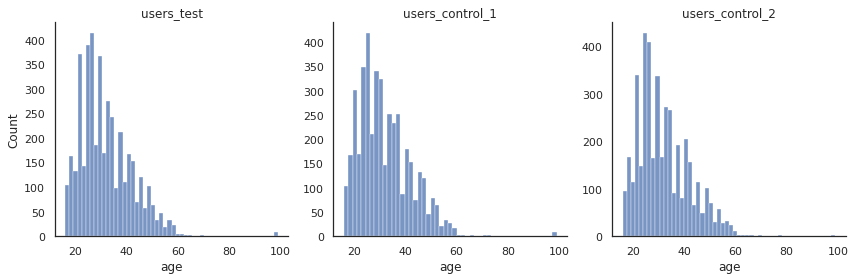

In [1014]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=users_test.age, ax = axes[0])
axes[0].set(title='users_test')

sns.histplot(x=users_control_1.age, ax = axes[1])
axes[1].set(title='users_control_1', ylabel='')

sns.histplot(x=users_control_2.age, ax = axes[2])
axes[2].set(title='users_control_2', ylabel='')

sns.despine()
plt.tight_layout()

Найдем средний возраст в каждой группе

In [1015]:
users_test.age.mean()

31.889275766016713

In [1016]:
users_control_1.age.mean()

32.08775981524249

In [1017]:
users_control_2.age.mean()

32.03483172511179

Проверим общий средний возраст

In [1018]:
users.age.mean()

31.999688497780546

In [1019]:
pg.normality(data=users, dv="age", group="group", method="normaltest")

,W,pval,normal
test,980.410906,1.277841e-213,False
control_1,912.976109,5.620265e-199,False
control_2,584.301416,1.319956e-127,False


Проверим распределение по гендеру

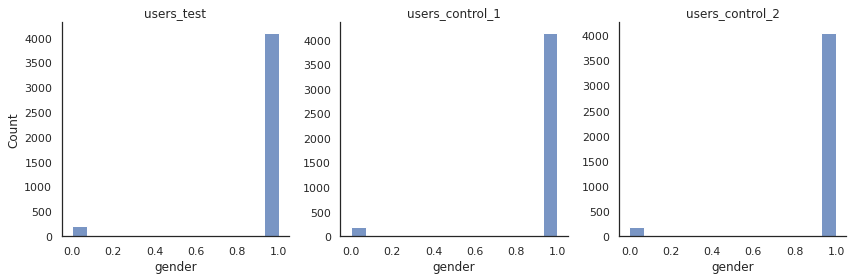

In [1020]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=users_test.gender, ax = axes[0])
axes[0].set(title='users_test')

sns.histplot(x=users_control_1.gender, ax = axes[1])
axes[1].set(title='users_control_1', ylabel='')

sns.histplot(x=users_control_2.gender, ax = axes[2])
axes[2].set(title='users_control_2', ylabel='')

sns.despine()
plt.tight_layout()

Найдем соотношение по половому признаку в каждй группе

Немного изменим данные в столбце gender, будем считать, что 1 - это обозначение мужчины, а  0 - женщины.

In [1021]:
users['gender']=users.gender.apply(lambda x:'man' if x ==1 else 'woman')

In [1022]:
gender_test = users.query('group == "test"').groupby('gender',as_index=False).agg({'uid':'count'})\
    .rename(columns={'uid': 'quantity'})

In [1023]:
gender_control_1 = users.query('group == "control_1"').groupby('gender',as_index=False).agg({'uid':'count'})\
    .rename(columns={'uid': 'quantity'})

In [1024]:
gender_control_2 = users.query('group == "control_2"').groupby('gender',as_index=False).agg({'uid':'count'})\
    .rename(columns={'uid': 'quantity'})

In [1025]:
gender_control_1

,gender,quantity
0,man,4135
1,woman,182


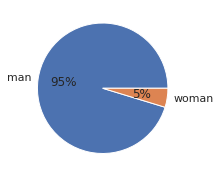

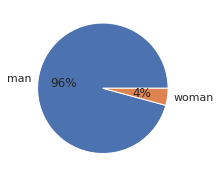

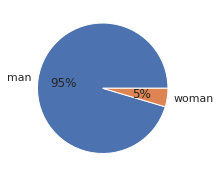

In [1026]:
sns.set(rc={'figure.figsize': (3, 3)})
plt.pie(gender_test.quantity, labels=gender_test.gender, autopct='%.0f%%')
plt.show()

sns.set(rc={'figure.figsize': (3, 3)})
plt.pie(gender_control_1.quantity, labels=gender_control_1.gender, autopct='%.0f%%')
plt.show()

sns.set(rc={'figure.figsize': (3, 3)})
plt.pie(gender_control_2.quantity, labels=gender_control_2.gender, autopct='%.0f%%')
plt.show()

Видим, что во всех трех группах преобладающее количество пользователей мкжчины 95 - 96 %

Посмотрим, из каких стран отобраны пользователи

In [1027]:
users_test.groupby('country',as_index = False).agg({'gender':'count'}).sort_values('gender',ascending=False).head(5)

,country,gender
48,United States of America,1450
1,Argentina,396
13,France,359
24,Italy,323
40,Spain,301


In [1028]:
users_control_1.groupby('country',as_index = False).agg({'gender':'count'}).sort_values('gender',ascending=False).head(5)

,country,gender
30,United States of America,1471
1,Argentina,389
10,France,370
23,Spain,342
14,Italy,338


In [1029]:
users_control_2.groupby('country',as_index = False).agg({'gender':'count'}).sort_values('gender',ascending=False).head(5)

,country,gender
29,United States of America,1486
0,Argentina,397
8,France,376
22,Spain,310
14,Italy,293


Пять крупнейших стран во всех трех группах распределены примерно одинаково

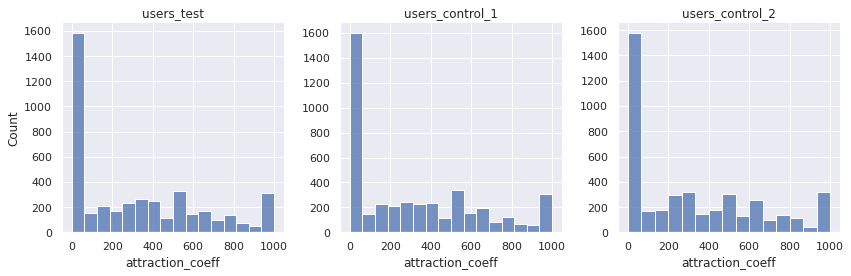

In [1030]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(x=users_test.attraction_coeff, ax = axes[0])
axes[0].set(title='users_test')

sns.histplot(x=users_control_1.attraction_coeff, ax = axes[1])
axes[1].set(title='users_control_1', ylabel='')

sns.histplot(x=users_control_2.attraction_coeff, ax = axes[2])
axes[2].set(title='users_control_2', ylabel='')

sns.despine()
plt.tight_layout()

In [1031]:
users_control_1.attraction_coeff.mean()

311.74387990762125

In [1032]:
users_control_2.attraction_coeff.mean()

317.7615909625794

In [1033]:
users_test.attraction_coeff.mean()

316.4113277623027

Проверим общее среднее

In [1034]:
users.attraction_coeff.mean()

315.14321314539364

In [1035]:
pg.normality(data=users, dv="attraction_coeff", group="group", method="normaltest")

,W,pval,normal
test,512.805188,4.423522e-112,False
control_1,492.639274,1.058622e-107,False
control_2,547.845990,1.088315e-119,False


Коэффициенты привлекательносьти тоже мало отличаются в трех группах

Делаем вывод,что система сплитования сработала нормально.

## Проводим АА Тесты

Давайте отпределимся с метриками, которые нам необходимо протестировать. 
Мы изменили только стоимость подписки в тестовой группе, поэтому наша целевая метрика - ARPPU (Average revenue per paying user) - средняя выручка на одного платящего пользователя c премиум-подпиской.

Также предлагаю рассмотреть такую метрику CR_pr (конверсия)  в покупку премиум-подписки в первой и второй группах.

###  1 . ARPPU (Average revenue per paying user)

Вспомним, что использовать total_revenue из таблицы users нецелесообразно, так как в нем содежится выручка за более широкий период. В нашем случае будет правильнее сначала произвести в transactions группировку по юзерам, найти общую выручку по каждому и на этих данных посчитать ARPPU_pr.

In [1036]:
group_control_1_sum =  transactions.query('revenue > 0.0') \
    .query('group == "control_1"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'sum'}) \
    .rename(columns={'revenue': 'total_revenue'})

In [1037]:
group_control_1_mean = transactions.query('revenue > 0.0') \
    .query('group == "control_1"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'mean'}) \
    .rename(columns={'revenue': 'mean_revenue'})

In [1038]:
group_control_2_sum =  transactions.query('revenue > 0.0') \
    .query('group == "control_2"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'sum'}) \
    .rename(columns={'revenue': 'total_revenue'})

In [1039]:
group_control_2_mean = transactions.query('revenue > 0.0') \
    .query('group == "control_2"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'mean'}) \
    .rename(columns={'revenue': 'mean_revenue'})

In [1040]:
group_control_1 = group_control_1_sum.merge(group_control_1_mean, on='uid')

In [1041]:
group_control_2 = group_control_2_sum.merge(group_control_2_mean, on='uid')

In [1042]:
group_control_1.head(3)

,uid,total_revenue,mean_revenue
0,891092322,5278.0,5278.0
1,891120969,6292.0,6292.0
2,891130164,4537.0,4537.0


Проверяем ARPPU_pr в друх группах

In [1043]:
group_control_1.total_revenue.mean()

7742.878787878788

In [1044]:
group_control_2.total_revenue.mean()

7287.465346534654

In [1045]:
group_control_1.total_revenue.mean() - group_control_2.total_revenue.mean()

455.4134413441343

Мы видим, что в группе control_1 среднее ARPPU_pr на 455,41 больше, чем в группе control_2, но является ли это различие статистически значимым? 

Посмотрим на распределение этих двух выборок

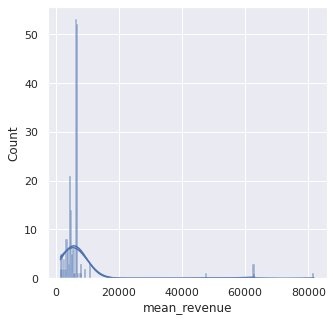

In [1046]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.histplot((group_control_1.mean_revenue), kde = True)
sns.histplot((group_control_2.mean_revenue), kde = True)

Проверим, одинаковые ли дисперсии в группах

H0 - дисперсии в группах равны

H1 - дисперсии не равны

In [1047]:
pg.homoscedasticity(data=transactions.query('group != "test" & product_type == "premium_no_trial"').groupby(['uid', 'group'], as_index=False).agg({'revenue' : 'sum'}), dv="revenue", group="group")

,W,pval,equal_var
levene,0.260895,0.610075,True


Значение pval больше 0.05, equal_var = True, значит принимаем нулевую гипотезу.

Дисперсии в группах равны и число наблюдений больше 30.
Таким образом мы можем использовать  t-критерия Стьюдента, так как мы работаем с количественными переменными для сравнения средних.

Строим гипотезы:

H0 - изменение цены подписки не влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской.

H1 - изменение цены подписки влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской.

In [1048]:
from scipy import stats
stats.ttest_ind((group_control_1.mean_revenue),(group_control_2.mean_revenue))

Ttest_indResult(statistic=0.31040696234577486, pvalue=0.7565779954115439)

Интерпретируем результат

In [1049]:
pvalue=0.7565779954115439
if pvalue >= 0.05:
    print ('Не отклоняем H0')
else:
    print('Отклоняем H0')

Не отклоняем H0


Не отклоняем Н0 и можем считать, что изменение цены подписки не влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской между двумя контрольными группами, система сплитования сработала хорошо

###  2 . CR  в покупку премиум-подписки

Объединим всех юзеров с транзакциями

In [1050]:
users_merge = users.merge(transactions, on='uid', how='left')

In [1051]:
users_merge['premium'] = users_merge.product_type.apply(lambda x:'premium_no_trial' if x == "premium_no_trial" else 'others')

In [1052]:
users_merge.groupby('premium').agg({'gender':'count'})

,gender
premium,
others,12576
premium_no_trial,284


Посмотрим на наши распределения на графике

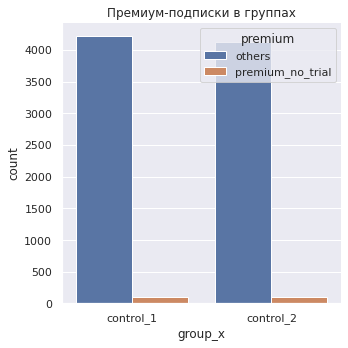

In [1053]:
sns.countplot(data=users_merge.query("group_x != 'test'").drop_duplicates(subset=['uid']), x = 'group_x', hue = 'premium')

sns.despine()
plt.title('Премиум-подписки в группах')
plt.tight_layout()

Визуально понятно, что премиальных подписок в обеих группах примерно одинаковое количество, но "прочих" явно меньше в группе control_2

In [1054]:
crosstab = pd.crosstab(users_merge.drop_duplicates(subset=['uid']).premium, users_merge.drop_duplicates(subset=['uid']).group_x).drop(columns='test')
crosstab

group_x,control_1,control_2
premium,,
others,4218,4128
premium_no_trial,99,101


Считаем конверсию для двух групп

In [1055]:
CR_pr_control_2 = transactions_control_2.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique() / users_control_2.uid.nunique()
CR_pr_control_2

0.02377029889385738

In [1056]:
CR_pr_control_1 = transactions_control_1.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique() / users_control_1.uid.nunique()
CR_pr_control_1

0.022863741339491917

In [1057]:
CR_pr_control_2 - CR_pr_control_1

0.0009065575543654621

В control_2 конверсия в премиум-покупку выше, чем в control_1 на 0.0009.
Но является ли это изменение статистически значимым? 

Предлагаю провести статистический тест с использованием Критерия Хи-квадрат (или критерий согласия Пирсона), так как мы имеем два категориальные переменные.
Строим гипотезы:


H0 - изменение цены подписки не влияет на факт покупки премиум-аккаунта, статистически значимой разницы между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе нет

H1 - изменение цены подписки влияет на факт покупки премиум-аккаунта, статистически значимая разница между распределениями пользователей в зависимости от подписки есть

In [1058]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merge.drop_duplicates(subset=['uid']).premium, users_merge.drop_duplicates(subset=['uid']).group_x).drop(columns='test'))

In [1059]:
stat, p

(0.047927557952542145, 0.8267095349720175)

In [1060]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print ('Отклоняем H0')
else:
    print('Не отклоняем H0')

Не отклоняем H0


Второй тест с новой метрикой также показал, что группы control_1 и control_2 сплитированы корректно, нулевую гипотезу принимаем.

Изменение цены подписки не влияет на факт покупки премиум-аккаунта, статистически значимой разницы между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе нет

можно переходить к АБ тестам

## Проводим АБ Тесты

Предлагаю проводить тест на группами control_2 и test, потому как в control_1 были большие выбросы и нам пришлось вносить изменения в датафрейм на этапе предобработки данных

### 1.  ARPPU_pr (Average revenue per paying user) средняя выручка на одного платящего пользователя c премиум-подпиской

Вспомним, что использовать total_revenue из таблицы users нецелесообразно, так как в нем содежится выручка за более широкий период. В нашем случае будет правильнее сначала произвести в transactions группировку по юзерам, найти общую выручку по каждому, а затем посчитать среднюю выручку на одного платящего пользователя.

In [1061]:
group_test_sum =  transactions.query('revenue > 0.0') \
    .query('group == "test"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'sum'}) \
    .rename(columns={'revenue': 'total_revenue'})

In [1062]:
group_test_mean = transactions.query('revenue > 0.0') \
    .query('group == "test"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'mean'}) \
    .rename(columns={'revenue': 'mean_revenue'})

In [1063]:
group_control_2_sum =  transactions.query('revenue > 0.0') \
    .query('group == "control_2"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'sum'}) \
    .rename(columns={'revenue': 'total_revenue'})

In [1064]:
group_control_2_mean = transactions.query('revenue > 0.0') \
    .query('group == "control_2"') \
    .query('product_type == "premium_no_trial"') \
    .groupby('uid',as_index = False).agg({'revenue':'mean'}) \
    .rename(columns={'revenue': 'mean_revenue'})

In [1065]:
group_test = group_test_sum.merge(group_test_mean, on='uid')

In [1066]:
group_control_2 = group_control_2_sum.merge(group_control_2_mean, on='uid')

Проверяем ARPPU_pr в друх группах

In [1067]:
group_test.total_revenue.mean()

11962.522388059702

In [1068]:
group_control_2.total_revenue.mean()

7287.465346534654

In [1069]:
group_test.total_revenue.mean() - group_control_2.total_revenue.mean()

4675.057041525049

Мы видим, что в группе test среднее ARPPU_pr на 4675.05 больше, чем в группе control_2, но является ли это различие статистически значимым? 

Посмотрим на распределение этих двух выборок

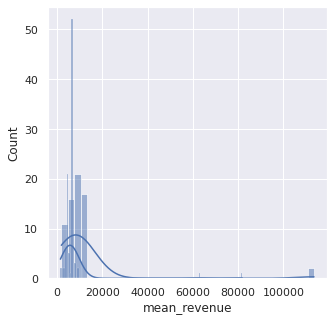

In [1070]:
sns.set(rc={'figure.figsize': (5, 5)})
sns.histplot((group_test.mean_revenue), kde = True)
sns.histplot((group_control_2.mean_revenue), kde = True)

Проверим, одинаковые ли дисперсии в группах

H0 - дисперсии в группах равны

H1 - дисперсии не равны

In [1071]:
pg.homoscedasticity(data=transactions.query('group != "control_1" & product_type == "premium_no_trial"').groupby(['uid', 'group'], as_index=False).agg({'revenue' : 'sum'}), dv="revenue", group="group")

,W,pval,equal_var
levene,2.659569,0.104824,True


Значение pval больше 0.05, equal_var = True, значит принимаем нулевую гипотезу.

Дисперсии в группах равны и число наблюдений больше 30.
Таким образом мы можем использовать  t-критерия Стьюдента, так как мы работаем с количественными переменными для сравнения средних.

Строим гипотезы:

H0 - изменение цены подписки не влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской.

H1 - изменение цены подписки влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской.

In [1072]:
from scipy import stats
stats.ttest_ind((group_test.mean_revenue),(group_control_2.mean_revenue))

Ttest_indResult(statistic=1.9742412620412333, pvalue=0.05001336451641004)

Итерпретируем результат

In [1073]:
pvalue=0.05001336451641004
if pvalue >= 0.05:
    print ('Не отклоняем H0')
else:
    print('Отклоняем H0')

Не отклоняем H0


Не отклоняем H0 и делаем вывод, изменение цены подписки не влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской.

###  2 . CR  в покупку премиум-подписки (CR_pr)

Объединим всех юзеров с транзакциями

In [1074]:
users_merge = users.merge(transactions, on='uid', how='left')

In [1075]:
users_merge['premium'] = users_merge.product_type.apply(lambda x:'premium_no_trial' if x == "premium_no_trial" else 'others')

Посмотрим на наши распределения на графике

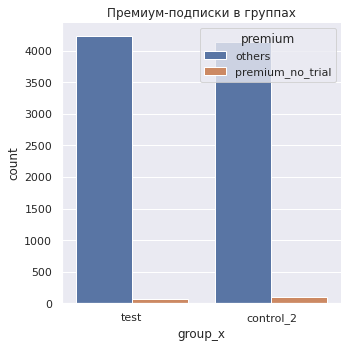

In [1076]:
sns.countplot(data=users_merge.query("group_x != 'control_1'").drop_duplicates(subset=['uid']), x = 'group_x', hue = 'premium')

sns.despine()
plt.title('Премиум-подписки в группах')
plt.tight_layout()

Визуально понятно, что премиальных подписок в группе control_2 больше

In [1077]:
crosstab = pd.crosstab(users_merge.drop_duplicates(subset=['uid']).premium, users_merge.drop_duplicates(subset=['uid']).group_x).drop(columns='control_1')
crosstab

group_x,control_2,test
premium,,
others,4128,4228
premium_no_trial,101,67


Считаем конверсию в наших группах

In [1078]:
CR_pr_control_2 = transactions_control_2.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique() / users_control_2.uid.nunique()
CR_pr_control_2

0.02377029889385738

In [1079]:
CR_pr_test = transactions_test.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique() / users_test.uid.nunique()
CR_pr_test

0.015552460538532962

In [1080]:
CR_pr_control_2 - CR_pr_test

0.008217838355324417

В control_2 конверсия в премиум-покупку выше, чем в test на 0.00821.
Но является ли это изменение статистически значимым? 

Предлагаю провести статистический тест с использованием Критерия Хи-квадрат (или критерий согласия Пирсона), так как мы имеем два категориальные переменные.
Строим гипотезы:


H0 - изменение цены подписки не влияет на факт покупки премиум-аккаунта, статистически значимой разницы между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе нет

H1 - изменение цены подписки влияет на факт покупки премиум-аккаунта, статистически значимая разница между распределениями пользователей в зависимости от подписки есть

In [1081]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(users_merge.drop_duplicates(subset=['uid']).premium, users_merge.drop_duplicates(subset=['uid']).group_x).drop(columns='control_1'))

In [1082]:
stat, p

(7.144473124816267, 0.007519536272015592)

In [1083]:
prob = 0.95
critical = chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print ('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Тест показал, что разница количества premium подписок в двух группах статистически значима, Отклоняем HO, изменение цены подписки влияет на факт покупки премиум-аккаунта, статистически значимая разница между распределениями пользователей в зависимости от подписки есть

Создадим сводную таблицу с расчитанными метриками:

In [1088]:
pivot_table = []

users = users_test.uid.nunique()
premium_users = transactions_test.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique()
revenue = transactions_test.query('product_type == "premium_no_trial"').revenue.sum()
CR_pr = (premium_users/users)
ARPPU_pr = (revenue/premium_users)

pivot_table.append(pd.DataFrame(index = ['test'], data = {'users':users, 'premium_users':premium_users, 
                                                      'CR_pr':CR_pr, 'ARPPU_pr':ARPPU_pr}))
pivot_table = pd.concat(pivot_table)
pivot_table

,users,premium_users,CR_pr,ARPPU_pr
test,4308,67,0.015552,11962.522388


In [1089]:
pivot_table_2 = []

users = users_control_2.uid.nunique()
premium_users = transactions_control_2.query('revenue > 0 and product_type == "premium_no_trial"').uid.nunique()
revenue = transactions_control_2.query('product_type == "premium_no_trial"').revenue.sum()
CR_pr = (premium_users/users)
ARPPU_pr = (revenue/premium_users)

pivot_table_2.append(pd.DataFrame(index = ['control_2'], data = {'users':users, 'premium_users':premium_users,
                                                      'CR_pr':CR_pr, 'ARPPU_pr':ARPPU_pr}))

pivot_table_2 = pd.concat(pivot_table_2)
pivot_table_2

,users,premium_users,CR_pr,ARPPU_pr
control_2,4249,101,0.02377,7287.465347


In [1090]:
pivot_table_merged = pd.concat([pivot_table, pivot_table_2])
pivot_table_merged

,users,premium_users,CR_pr,ARPPU_pr
test,4308,67,0.015552,11962.522388
control_2,4249,101,0.023770,7287.465347


Сводная наблица наглядно показывает, что в тестовой группе CR_pr значительно ниже, премиальных пользователей меньше на 51 % меньше, хотя в тестовой количество юзеров больше. Средняя выручка на одного платящего пользователя с премиум-подпиской в тестовой группе выше, но не значительно.

## Выводы

Нам были предоставлены репрезентативные выборки, система сплитования сработала эффективно.

Средний возраст пользователей приложения 32 года, 95 % пользователей - мужчины.

Большая часть пользователей из США.

Нам пришлось удалить из первой контрольной группы строки с отсутствующими значениями, и дубли из таблицы transactions, после этого можно сказать, что количество пользователей во всех трех группах было примерно равным.

Мы выбрали группу Control_2 для проведения АБ тестов, так как в ней не было корректировок.


Так как в первую очередь нас интересовало увеличение выручки после изменения стоимости платной подписки, мы сравнили среднюю выручку платещего пользователя с премиум-подпиской ARPPU_pr (Average revenue per paying user), в тестовой группе ARPPU оказался выше, чем в контрольной на 4675.05.
Тест показал различие статистически незанчимым, принимаем HO и считаем, что изменение цены подписки не влияет на среднюю выручку на одного платящего пользователя с премиум-подпиской.

Также мы проверили такую метрику, как конверсия в премиум-подписку CR_pr. Она, наоборот, оказалась ниже в тестовой группе, чем в контрольной на  0.00821, тест показал данное различие  стат. значимым. и мы отклоники H0 - изменение цены подписки влияет на факт покупки премиум-аккаунта, статистически значимая разница между распределениями пользователей в зависимости от подписки (продлили/ не продлили) в тестовой и контрольной группе есть.

Эксперимент можно считать неудачным, так как с новой стоимостью подписки конверсия скорей всего будет продолжать падать, так как тест показал снижение стат. значимым, а выручка значительно расти не будет. В дальнейшем, с постепенным снижением конверсии мы увидим и снижение выручки, это лишь вопрос времени.